In [4]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

# base python modules
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multiprocessing import cpu_count
from skimage.restoration import unwrap_phase

# less standard modules
import pyfftw
import py4DSTEM

# our module
import stemh_tools as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# paths hard coded from your own device

dataPath = '/Users/andrewducharme/University of Oregon Dropbox/UO-McMorran Lab/ParticipantFiles/Ducharme/Data/STEMH/2306_NCEM_Magnetics/Data/23-06-07/ef_4dstem_edge.dm4'
savePath = '/Users/andrewducharme/University of Oregon Dropbox/UO-McMorran Lab/ParticipantFiles/Ducharme/Data/STEMH/2306_NCEM_Magnetics/Data/23-06-07/'

In [6]:
datacube = py4DSTEM.import_file(dataPath)
data = datacube.data
datacube

DataCube( A 4-dimensional array of shape (140, 200, 1024, 1024) called 'dm_dataset',
          with dimensions:

              Rx = [0.0,0.009856926277279854,0.019713852554559708,...] µm
              Ry = [0.0,0.009856926277279854,0.019713852554559708,...] µm
              Qx = [0.0,1.1456898751190524e-05,2.2913797502381047e-05,...] A^-1
              Qy = [0.0,1.1456898751190524e-05,2.2913797502381047e-05,...] A^-1
)

In [ ]:
datacube, hf_mask = datacube.filter_hot_pixels(thresh=0.05, return_mask=True)

In [7]:
scan_row_num = datacube.shape[0]  
scan_col_num = datacube.shape[1]  
frame_row_num = datacube.shape[2]
frame_col_num = datacube.shape[3]

print(scan_row_num, scan_col_num)
print(frame_row_num, frame_col_num)

140 200
1024 1024


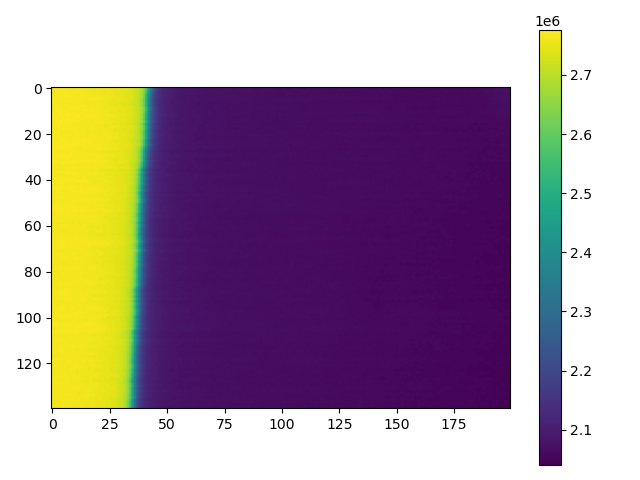

In [9]:
# create virtual STEM image of data

vSTEM = np.sum(datacube.data, axis=(2,3))

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(vSTEM)
plt.colorbar(im)

In [ ]:
fig.savefig(savePath + 'vSTEM.png')

Find the location of the peaks in the Fourier transform of an interference pattern. The peak location is essentially constant throughout the scan.

The code tries to find the correct value, but double-check that it isn't picking up the 0th order.

[825  31]
[630  61]


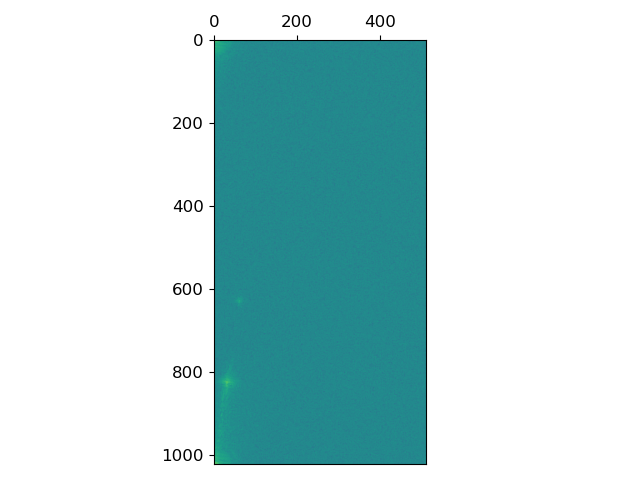

In [10]:
frame_location = np.unravel_index(np.argmax(vSTEM),vSTEM.shape)
test_frame = data[frame_location]

# find the first order index by computing the real fft to match what we use in the loop
test_rfft = np.fft.rfft2(test_frame)

first_order, second_order = st.find_fft_peaks(test_rfft)  # find 2 highest magnitude peaks in vac_rfft
print(first_order)
print(second_order)
orders=(first_order,second_order)

# Check the frame isn't obviously garbage.
# The code looks at the raw rFFT, but it's easier for us humans to look at the fftshifted rFFT
# Just remember Fourier peak locations in the fftshifted data are not the locations in the actual analysis
fig, ax = plt.subplots(tight_layout=True)

# ax.imshow(test_frame, cmap='binary')
ax.imshow(np.abs(test_rfft), norm=LogNorm())
# ax.imshow(np.abs(np.fft.fftshift(test_rfft)), norm=LogNorm())

ax.xaxis.tick_top()
ax.tick_params(labelsize = 12)

In [11]:
# setting up pyfftw numpy interface
pyfftw.config.NUM_THREADS = cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_ESTIMATE'
pyfftw.interfaces.cache.enable()

Total time (s): 195.2609601020813


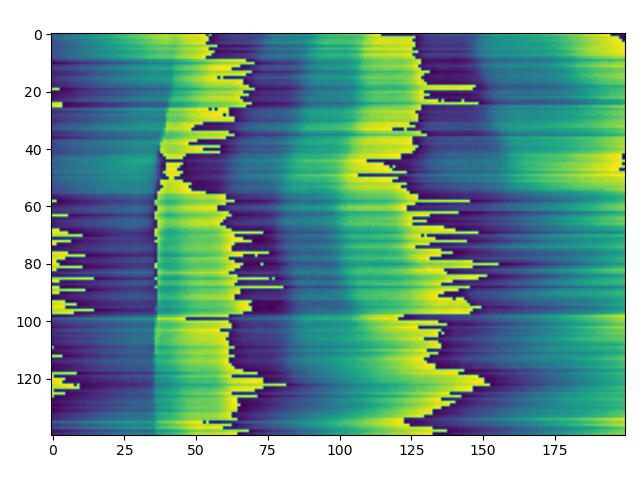

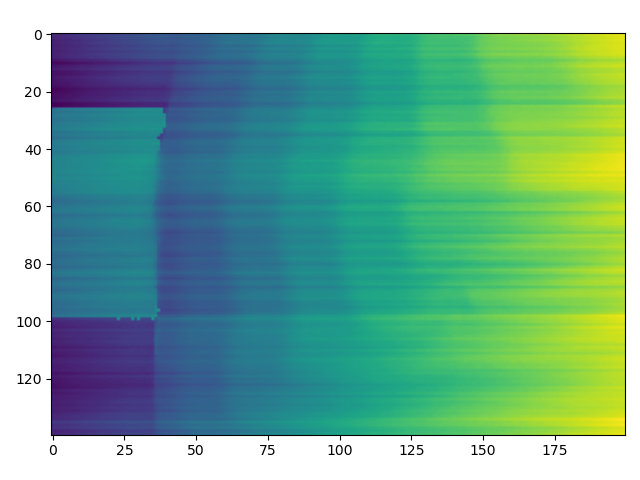

Total time (s): 223.52003383636475


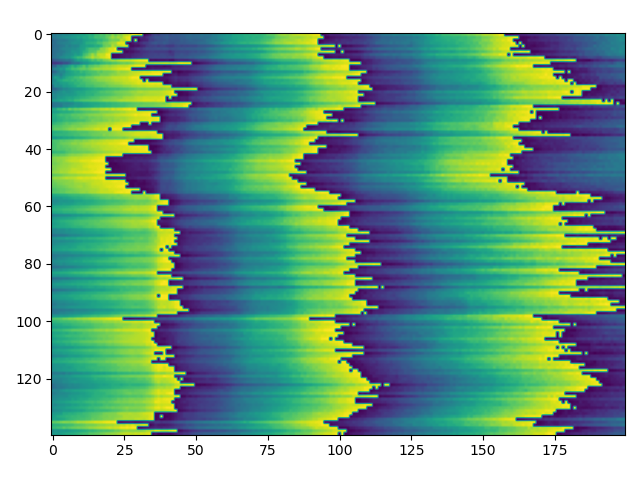

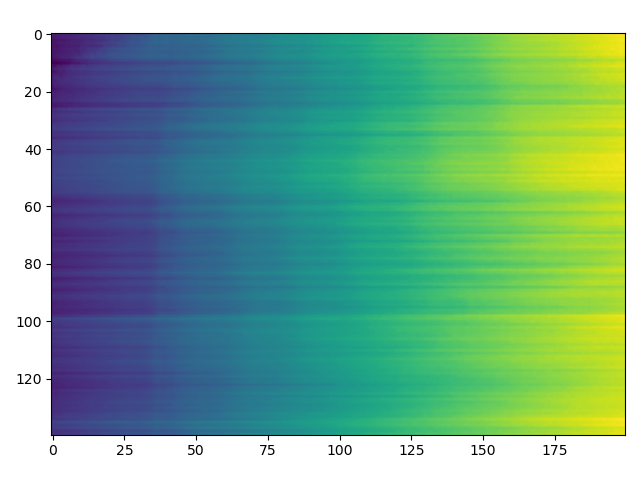

Total time (s): 212.57425093650818


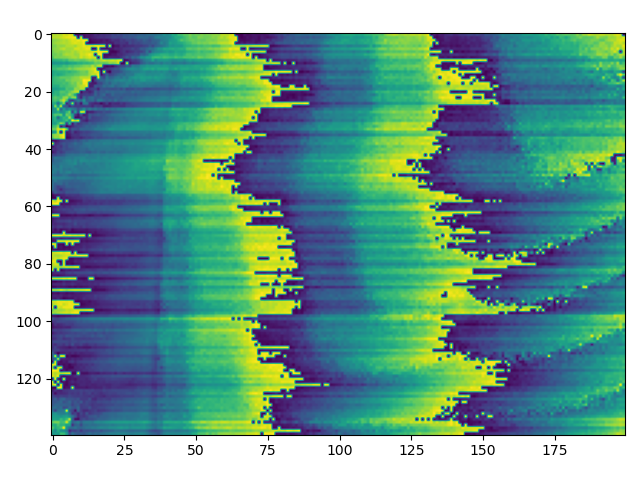

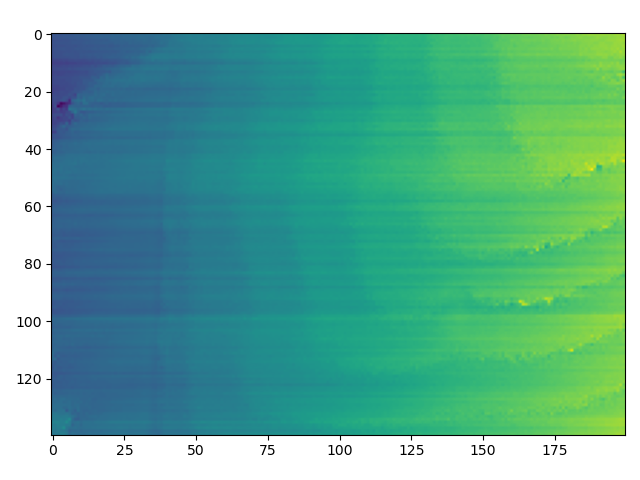

Total time (s): 201.3992838859558


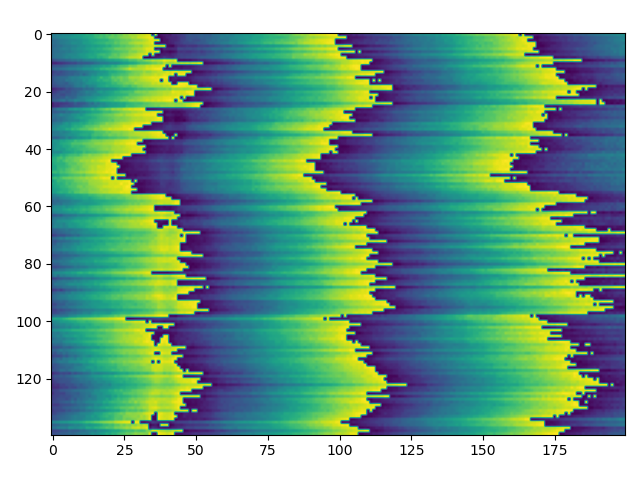

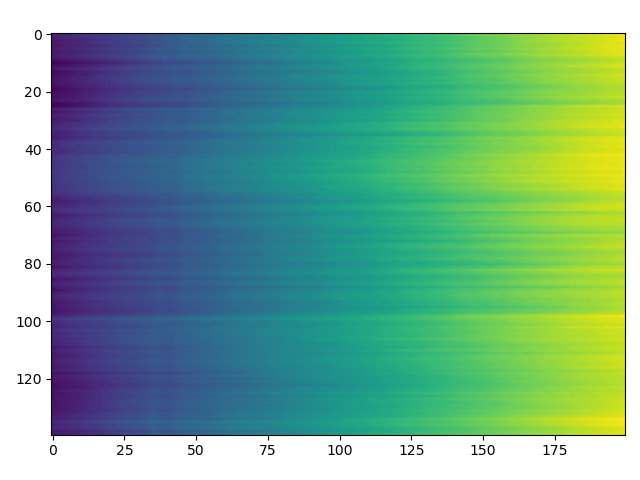

Total time (s): 191.847749710083


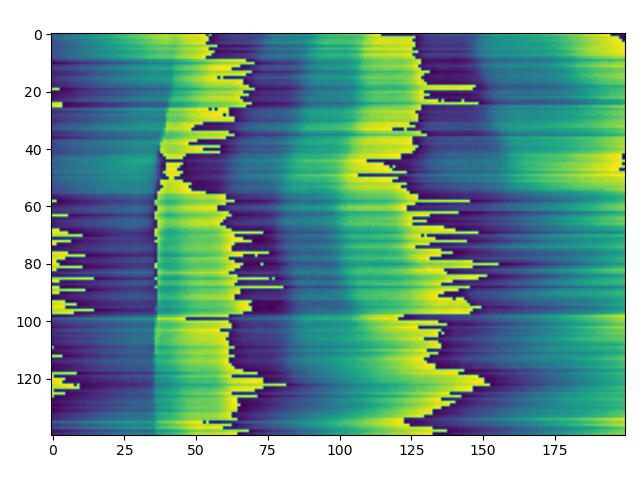

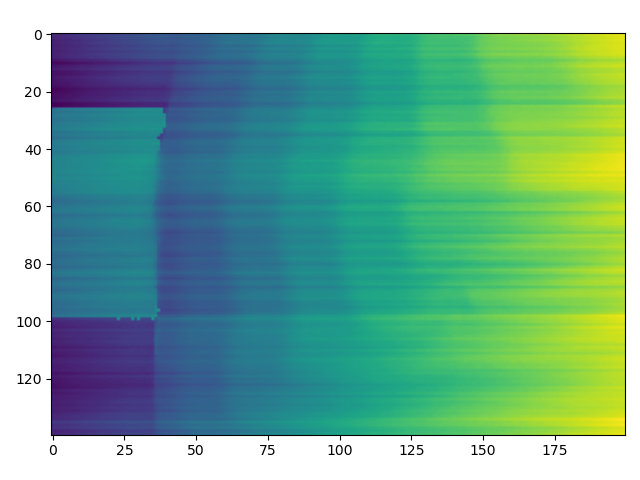

Total time (s): 208.7037000656128


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


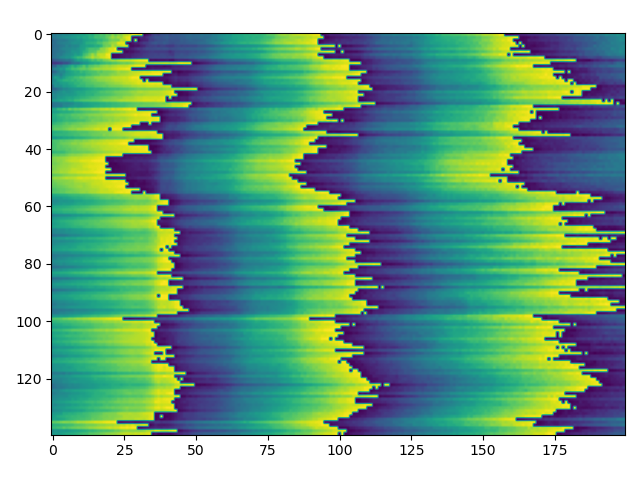

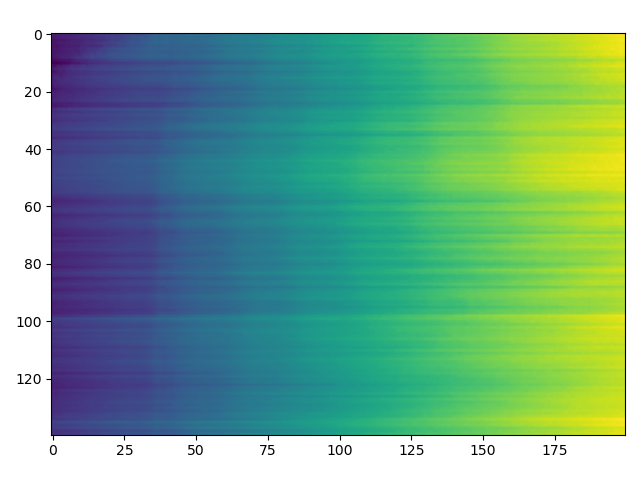

Total time (s): 211.25550627708435


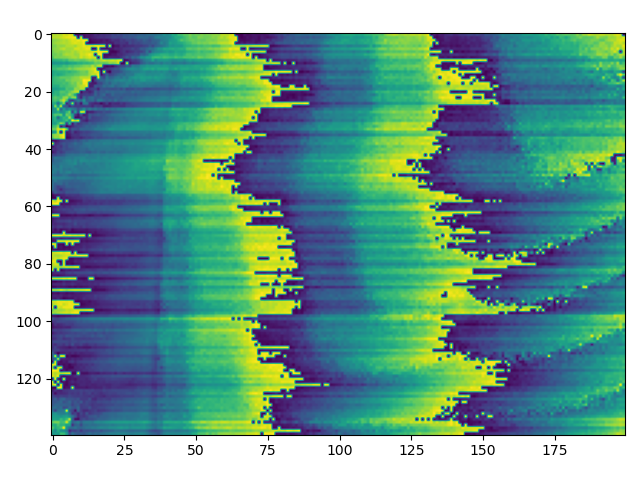

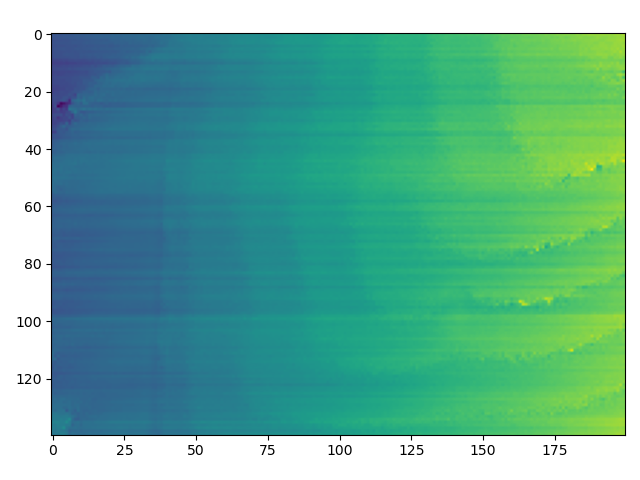

Total time (s): 210.39440894126892


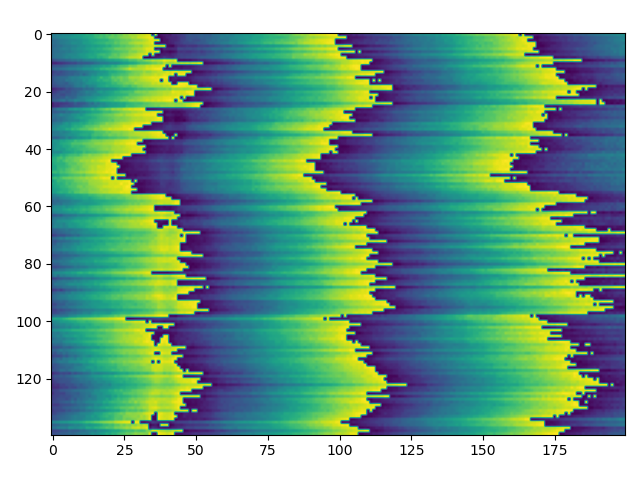

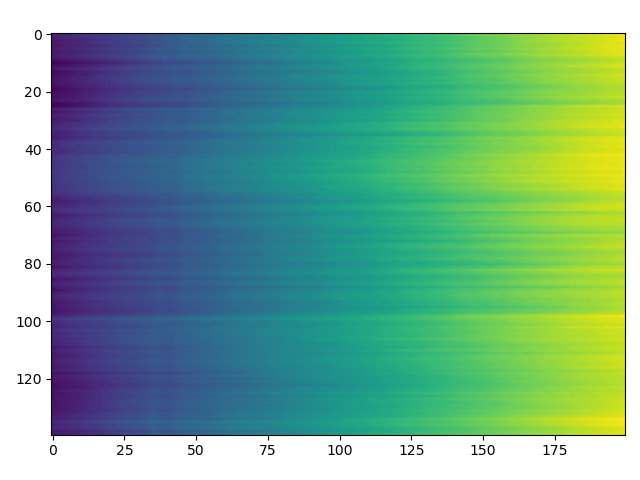

In [31]:
base = np.empty((frame_row_num, frame_col_num), dtype='float32')
    
# data array made 3D, from (scan_row, scan_col, : ,:) to (scan_row * scan_col, :,:)
num_frames = scan_col_num * scan_row_num
data1D = data.reshape((num_frames, frame_row_num, frame_col_num))

for i, order in enumerate(orders):
    order_num = i + 1
    for selection_size in [1,3,5,7]:
        # initialize arrays to store values through loop
        peaks = np.zeros(num_frames, dtype=complex)
    
        start = time.time()

        # the forward Fourier transform is the vast majority of the work+computation time here
        for i, frame in enumerate(data1D):
            base[:] = frame

            ft = pyfftw.interfaces.numpy_fft.rfft2(base)  # take Fourier transform of the windowed frame
            # ft = cupy.fft.rfft2(cupy.asarray(frame)) # uncomment for gpus

            fourier_space_peak = st.grab_box(ft, selection_size, first_order) # select the area around desired peak

            peaks[i] = np.sum(fourier_space_peak)

        phaseMap = np.angle(peaks).reshape((scan_row_num, scan_col_num))

        end = time.time()
        print("Total time (s): " + str(end - start))

        savePathDetails = 'phase_ord' + str(order_num) + '_ss' + str(selection_size)

        # plot and save raw reconstruction
        fig, ax = plt.subplots(tight_layout=True)
        ax.imshow(phaseMap)
        plt.show()
        
        fig.savefig(savePath + savePathDetails + '.png', dpi = 150)
        np.save(savePath + savePathDetails, phaseMap)

        # plot and save unwrapped and rough plane-subtracted reconstruction
        savePathDetails = 'phase_unwrapped_ord' + str(order_num) + '_ss' + str(selection_size)
        fig, ax = plt.subplots(tight_layout=True)
        ax.imshow(st.plane_subtract(unwrap_phase(phaseMap)))
        plt.show()
        
        fig.savefig(savePath + savePathDetails + '.png', dpi = 150)

In [ ]:
# check best locations for plane subtractions for phase map

loc = (100,20)

fig, ax = plt.subplots(tight_layout=True)
ax.xaxis.tick_top()
image = ax.imshow(st.plane_subtract(phaseMap,15,loc), cmap='seismic')
plt.colorbar(image)

plt.plot(loc[0],loc[1], 'ro')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [65]:
plt.close('all')